In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pylab
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.decomposition import NMF
from ksvd import ApproximateKSVD
from sklearn.model_selection import train_test_split
from mylibrary import my_cross_val_score, plot_ssp, creatMas

In [3]:
ocean = 'BarentsSea'

In [4]:
with open('{0}/CZ.txt'.format(ocean), 'r') as f:
    line = f.readlines()
CZ=creatMas(line)
with open('{0}/zs.txt'.format(ocean), 'r') as f:
    line = f.readlines()
    line = line[:-1]
zs = [-int(a) for a in line]
N_cord=len(zs)

In [5]:
CZ_train, CZ_test = train_test_split(CZ)
CZ.shape, CZ_train.shape, CZ_test.shape

((150, 12), (112, 12), (38, 12))

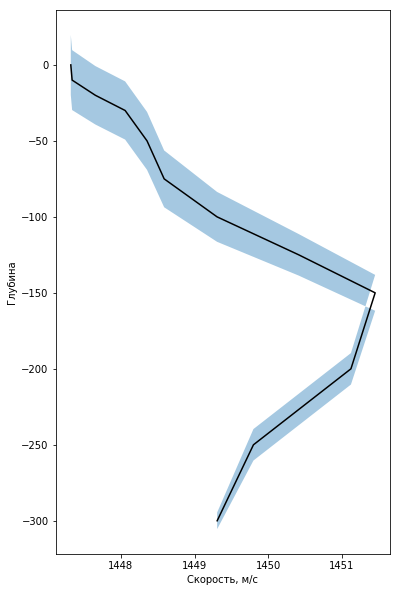

In [6]:
x  = np.array(CZ)
x_std = np.std(x, axis=0)
x_mean = np.mean(x, axis=0)
plt.figure(figsize=(6,10))
plt.plot(x_mean,zs, 'k')
plt.ylabel('Глубина')
plt.xlabel('Скорость, м/с')
plt.fill_between(x_mean, zs - 3*x_std, zs + 3*x_std, alpha=0.4)
plt.show()

Метод PCA:

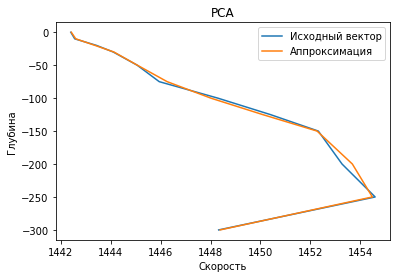

In [7]:
pca = decomposition.PCA(n_components=5)
pca.fit(CZ_train)
CZ_reconstructed_pca = pca.inverse_transform(pca.transform(CZ_test))
reduced = CZ_reconstructed_pca
plot_ssp(CZ_test[4], reduced[4], zs, 'PCA')

In [8]:
mean_squared_error(CZ_test[4], reduced[4])

0.03914070640583807

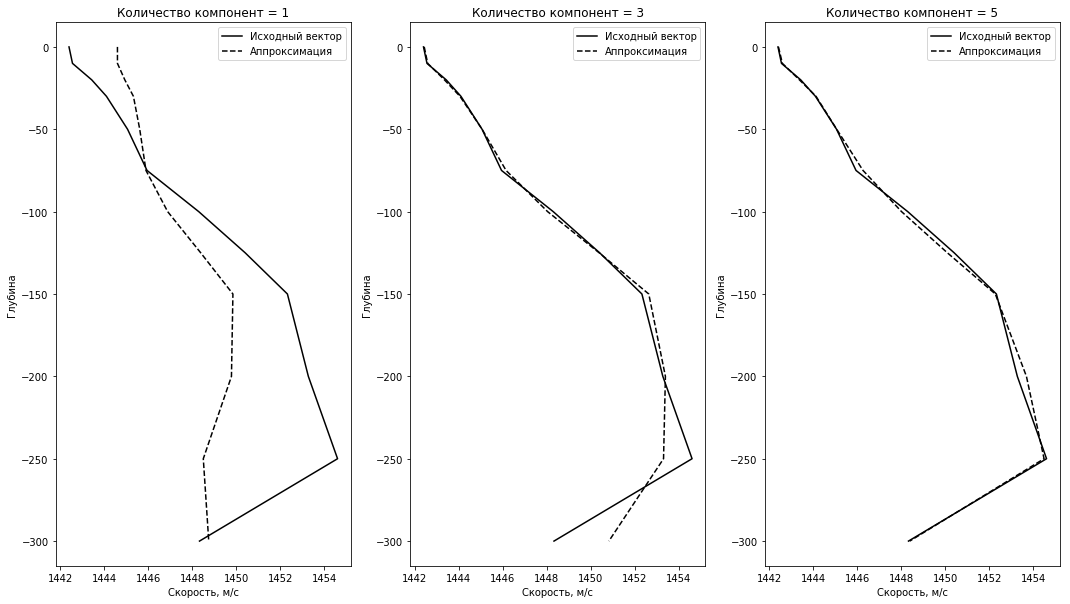

In [9]:
nc = [1, 3, 5]
i = 1
plt.figure(figsize=(18,10))
for nco in nc:
    pca = decomposition.PCA(n_components=nco)
    pca.fit(CZ_train)
    CZ_reconstructed_pca = pca.inverse_transform(pca.transform(CZ_test))
    reduced = CZ_reconstructed_pca
    plt.subplot(1, 3, i)
    plt.plot(CZ_test[4], zs, c='k')
    plt.plot(reduced[4], zs,'k--', c='k')
    plt.legend(['Исходный вектор', 'Аппроксимация'])
    plt.ylabel('Глубина')
    plt.xlabel('Скорость, м/с')
    plt.title('Количество компонент = {}'.format(nco))
    i += 1
plt.show()

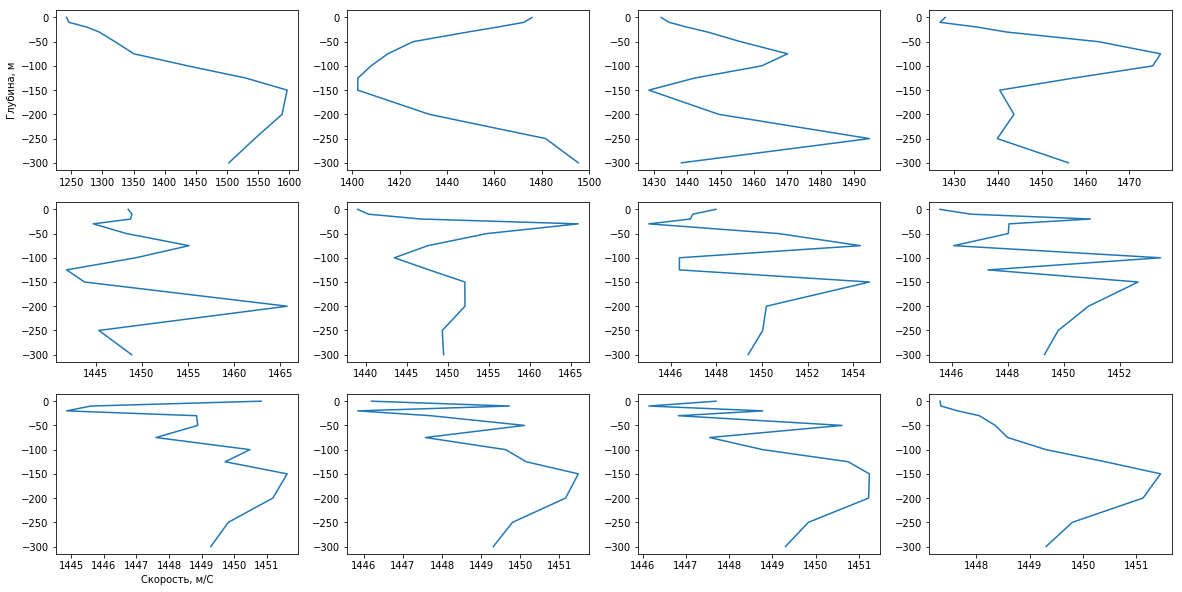

In [8]:
pca = decomposition.PCA(n_components=N_cord)
CZ_reduced = pca.fit_transform(CZ_train.T)
import pylab
plt.figure(figsize=(20,10))
for i in range(0,N_cord):
    pylab.subplot (3, N_cord/3, i+1)
    pylab.plot (CZ_reduced[:,i]*x_std+x_mean, zs)
    if i == 8:
        plt.xlabel('Скорость, м/С')
    if i == 0:
        plt.ylabel('Глубина, м')
pylab.show()

Метод NMF:

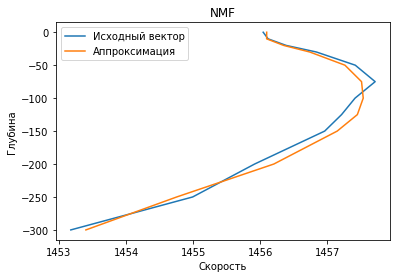

In [66]:
nmf = NMF(n_components=5, random_state=0)
nmf.fit(CZ_train)
CZ_reconstructed_nmf = np.dot(nmf.transform(CZ_test), nmf.components_)
reduced = CZ_reconstructed_nmf
plot_ssp(CZ_test[0], reduced[0], zs, 'NMF')

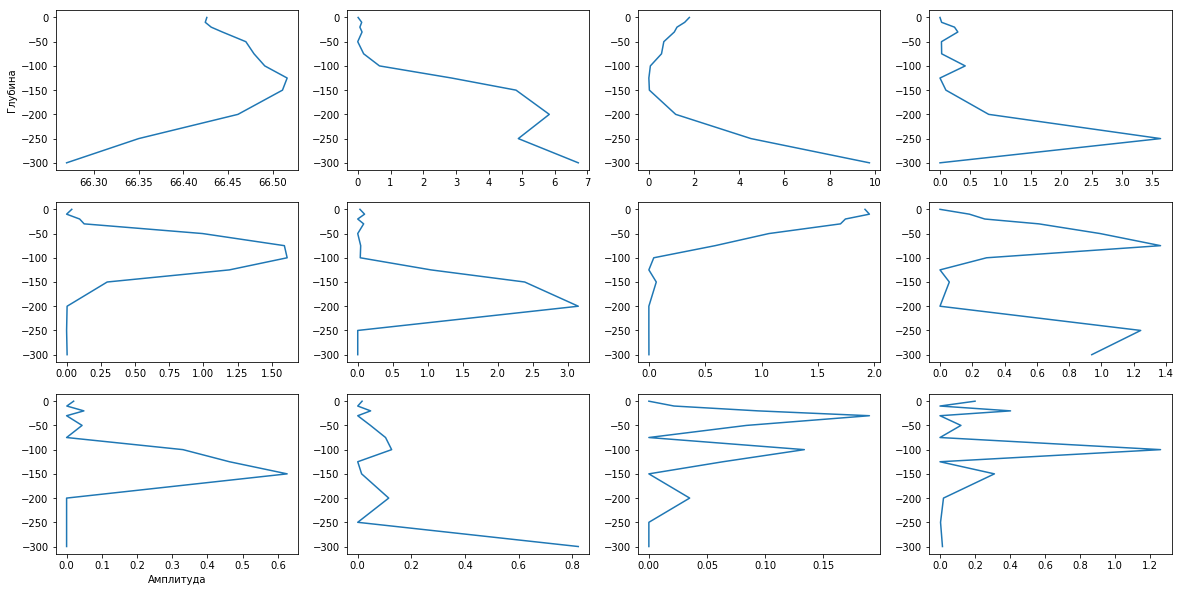

In [36]:
nmf = NMF(n_components=N_cord)
CZ_reduced = nmf.fit_transform(CZ_train.T)
import pylab
plt.figure(figsize=(20,10))
for i in range(0,N_cord):
    pylab.subplot (3, N_cord/3, i+1)
    pylab.plot (CZ_reduced[:,i], zs)
    if i == 8:
        plt.xlabel('Амплитуда')
    if i == 0:
        plt.ylabel('Глубина')
pylab.show()

Метод K-means:

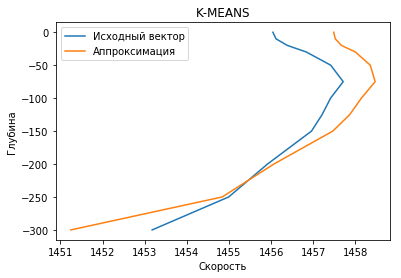

In [70]:
kmeans = KMeans(n_clusters = 3, random_state = False)
kmeans.fit(CZ_train)
CZ_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(CZ_test)]
reduced = CZ_reconstructed_kmeans
plot_ssp(CZ_test[0], reduced[0], zs, 'K-MEANS')

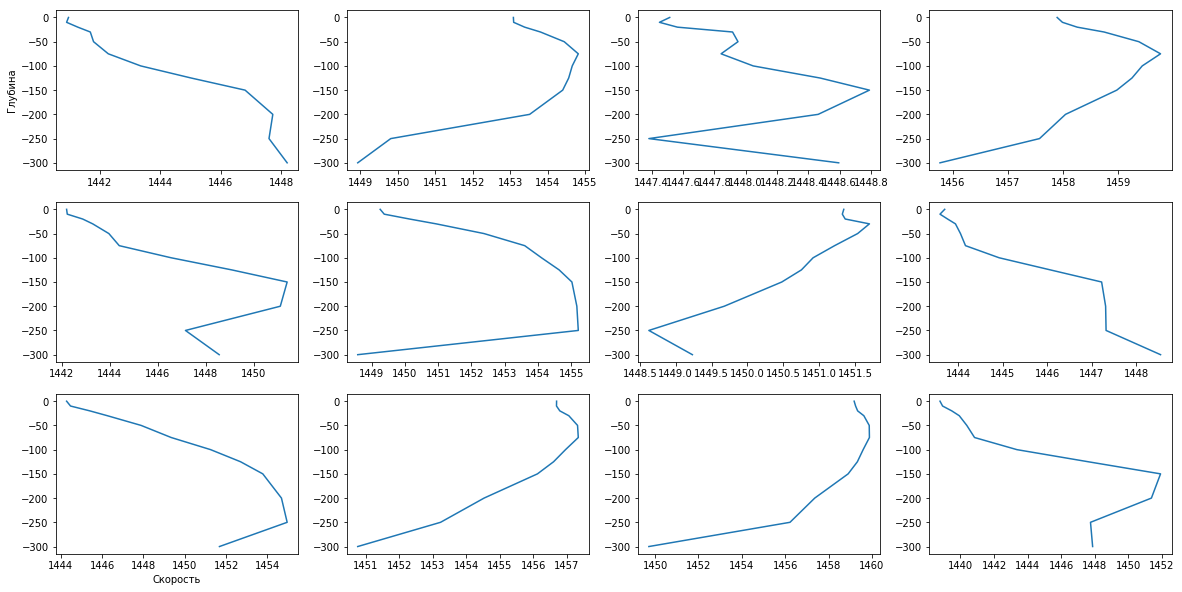

In [37]:
kmeans = KMeans(n_clusters = 12, random_state = False)
kmeans.fit(CZ_train)
plt.figure(figsize=(20,10))
for i in range(12):
    pylab.subplot (3, N_cord/3, i+1)
    pylab.plot(kmeans.cluster_centers_[i], zs)
    if i == 8:
        plt.xlabel('Скорость')
    if i == 0:
        plt.ylabel('Глубина')

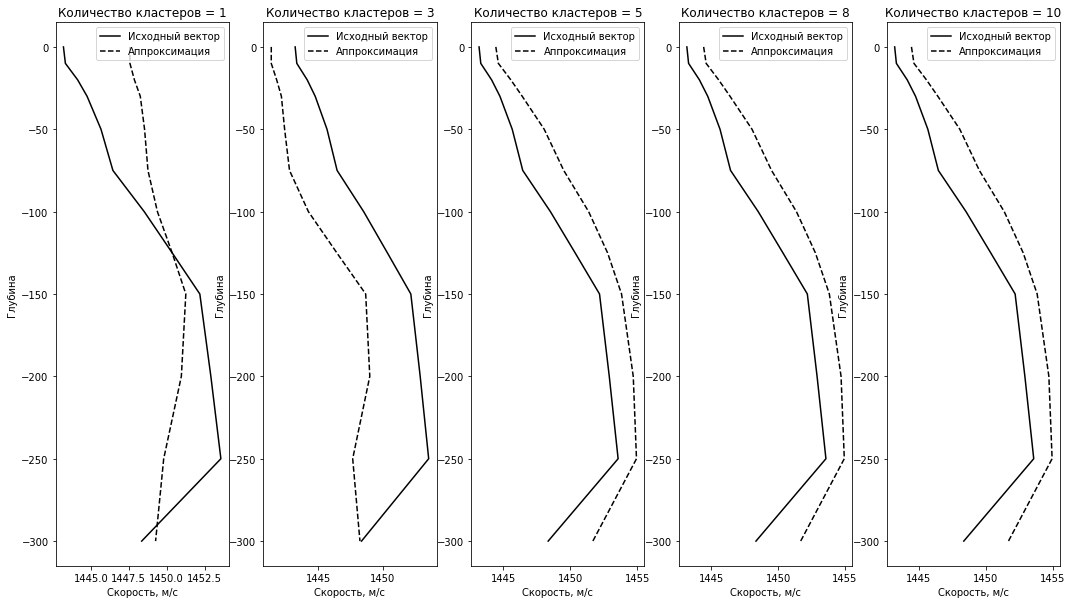

In [71]:
nc = [1, 3, 5, 8, 10]
i = 1
plt.figure(figsize=(18,10))
for nco in nc:
    kmeans = KMeans(n_clusters = nco, random_state = False)
    kmeans.fit(CZ_train)
    CZ_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(CZ_test)]
    reduced = CZ_reconstructed_kmeans
    pylab.subplot(1, len(nc), i)
    pylab.plot(CZ_test[4], zs, c='k')
    pylab.plot(reduced[4], zs,'k--', c='k')
    pylab.legend(['Исходный вектор', 'Аппроксимация'])
    pylab.ylabel('Глубина')
    pylab.xlabel('Скорость, м/с')
    plt.title('Количество кластеров = {}'.format(nco))
    i += 1
pylab.show()

In [81]:
mse = []
for nco in nc:
    kmeans = KMeans(n_clusters = nco, random_state = False)
    kmeans.fit(CZ_train)
    CZ_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(CZ_test)]
    reduced = CZ_reconstructed_kmeans
    mse.append(mean_squared_error(CZ_test[4], reduced[4]))
mse

[5.397568110945088, 5.397568110945088, 5.397568110945088]

Метод K-SVD:

In [38]:
mse = []
for nn in range(1,N_cord):
    ksvd = ApproximateKSVD(n_components=N_cord-1, transform_n_nonzero_coefs=nn)             
    meantr = np.mean(CZ_train,axis=0)
    dictionary = ksvd.fit(CZ_train - meantr).components_
    gamma = ksvd.transform(CZ_test - meantr)
    reduced = gamma.dot(dictionary) + meantr
    #plot_ssp(CZ_test[0], reduced[0], zs, 'K-SVD')    
    mse.append(mean_squared_error(CZ_test, reduced))

In [53]:
ksvd = ApproximateKSVD(n_components=4)             
meantr = np.mean(CZ_train,axis=0)
dictionary = ksvd.fit(CZ_train - meantr).components_
gamma = ksvd.transform(CZ_test - meantr)
reduced = gamma.dot(dictionary) + meantr

In [40]:
gamma[0]

array([ 0.        ,  0.        ,  0.        , 22.08180707])

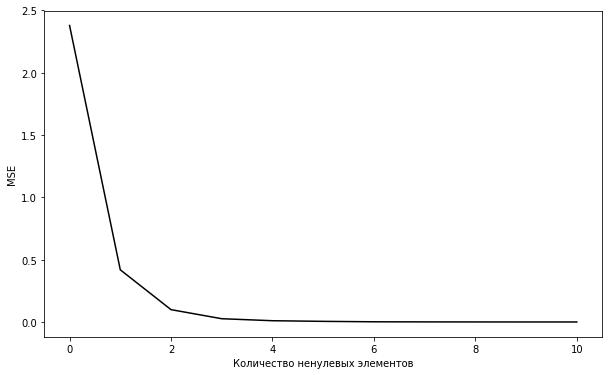

In [26]:
plt.figure(figsize=(10,6))
plt.plot(mse, 'k')
plt.ylabel("MSE")
plt.xlabel("Количество ненулевых элементов")
plt.show()

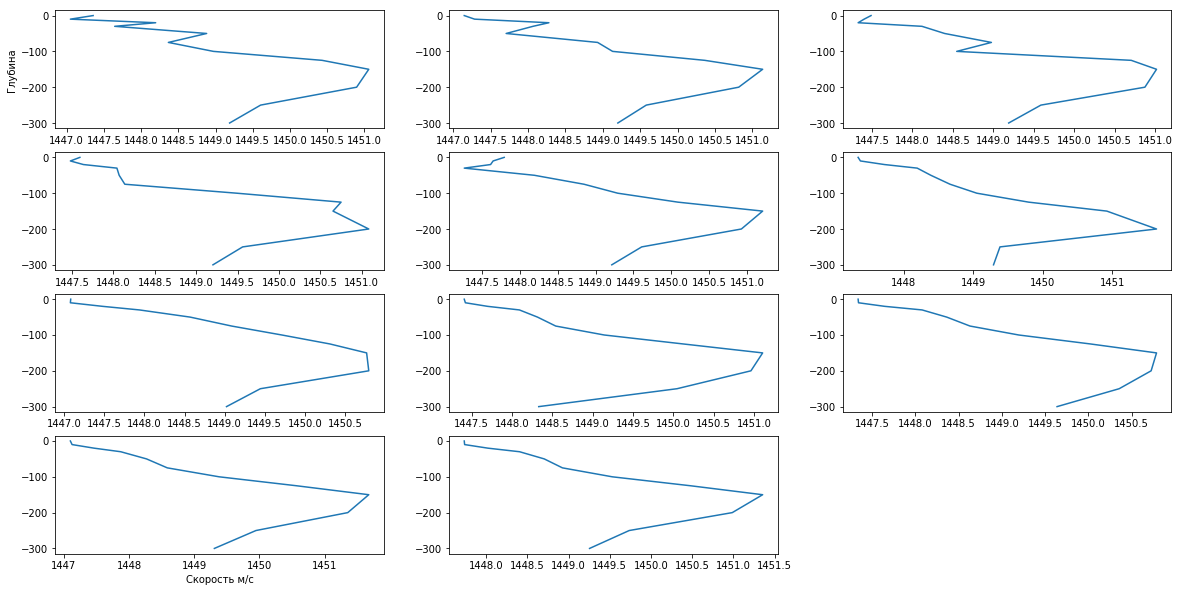

In [75]:
ksvd = ApproximateKSVD(n_components=N_cord-1, transform_n_nonzero_coefs=N_cord-1)
meantr = np.mean(CZ_train,axis=0)
dictionary = ksvd.fit(CZ_train - meantr).components_
plt.figure(figsize=(20,10))
for i in range(0,N_cord-1):
    pylab.subplot (4, N_cord/4, i+1)
    pylab.plot (dictionary[i] + meantr, zs)
    if i == 9:
        plt.xlabel('Скорость м/с')
    if i == 0:
        plt.ylabel('Глубина')
pylab.show()

In [7]:
nc = [6, 8, 10]
i = 1
plt.figure(figsize=(18,10))
for nco in nc:
    ksvd = ApproximateKSVD(n_components=nco, transform_n_nonzero_coefs=nco-5)
    meantr = np.mean(CZ_train,axis=0)
    dictionary = ksvd.fit(CZ_train - meantr).components_
    gamma = ksvd.transform(CZ_test - meantr)
    reduced = gamma.dot(dictionary) + meantr
    pylab.subplot(1, len(nc), i)
    pylab.plot(CZ_test[4], zs, c='k')
    pylab.plot(reduced[4], zs,'k--', c='k')
    pylab.legend(['Исходный вектор', 'Аппроксимация'])
    pylab.ylabel('Глубина')
    pylab.xlabel('Скорость, м/с')
    plt.title('k = {}'.format(nco))
    i += 1
pylab.show()

NameError: name 'pylab' is not defined

<Figure size 1296x720 with 0 Axes>

In [8]:
from comon import AEncoder
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


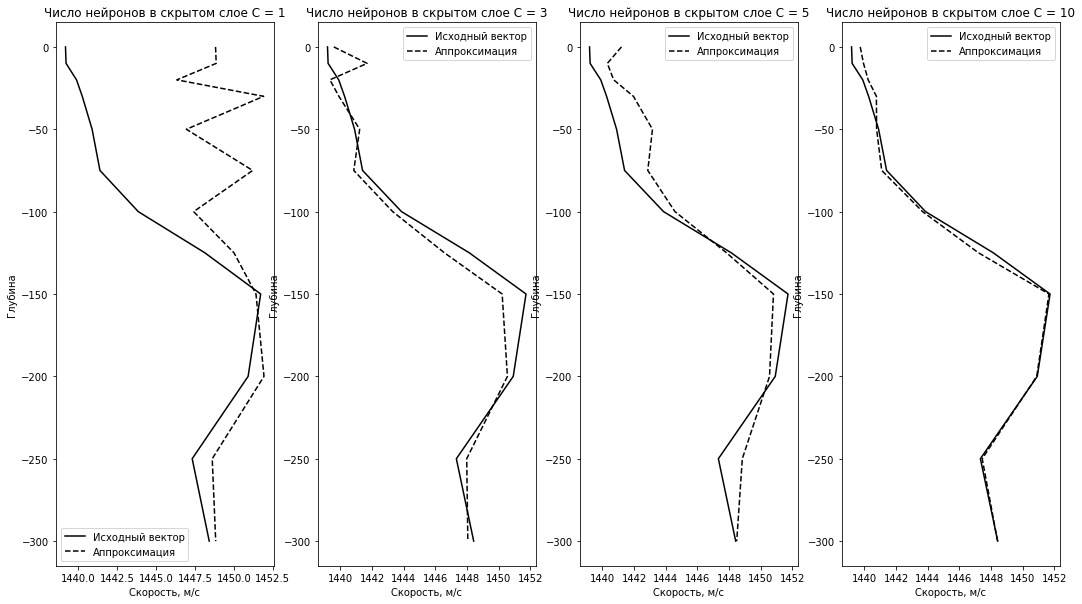

In [10]:
nc = [1, 3, 5, 10]
mse = []
i = 1
plt.figure(figsize=(18,10))
for nco in nc:
    autoencoder_std, encoder_std = AEncoder(N_cord, nco)
    scaler = StandardScaler()
    CZ_train_std = scaler.fit_transform(CZ_train)
    CZ_test_std = scaler.fit_transform(CZ_test)
    hist = autoencoder_std.fit(CZ_train_std, CZ_train_std,
                epochs=1000,
                batch_size=64,
                shuffle=True,
                validation_data=(CZ_test_std, CZ_test_std),verbose=0)

    predict_std = autoencoder_std.predict(CZ_test_std)
    predict = scaler.inverse_transform(predict_std)
    
    pylab.subplot(1, 4,i)
    pylab.plot(CZ_test[4], zs, c='k')
    pylab.plot(predict[4], zs,'k--', c='k')
    mse.append(mean_squared_error(CZ_test[4], predict[4]))
    pylab.legend(['Исходный вектор', 'Аппроксимация'])
    pylab.ylabel('Глубина')
    pylab.xlabel('Скорость, м/с')
    plt.title('Число нейронов в скрытом слое С = {}'.format(nco))
    i += 1
pylab.show()

Результаты перекрестной проверки

## Представление данных на плоскости

In [224]:
import umap

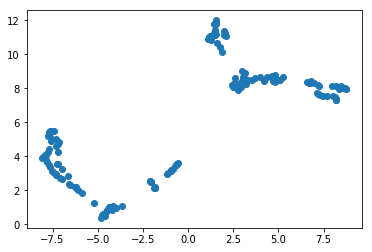

In [234]:
CZembedding = umap.UMAP().fit_transform(CZ)
plt.scatter(CZembedding[:,0], CZembedding[:,1])
plt.show()

## Кластеризация

**количество кластеров**

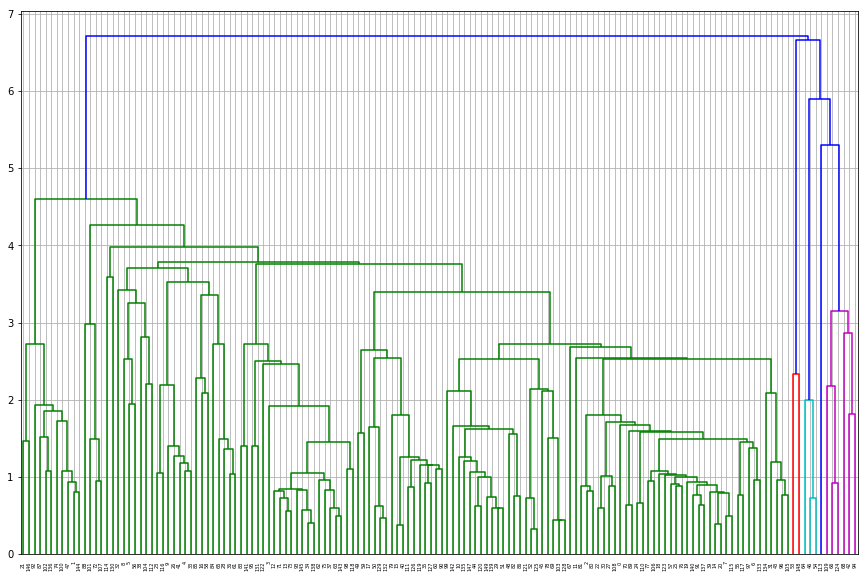

In [22]:
Z = pdist(CZ)
Z = linkage(Z, 'single')
plt.figure(figsize=(15,10))
plt.grid(True)
dn = dendrogram(Z)

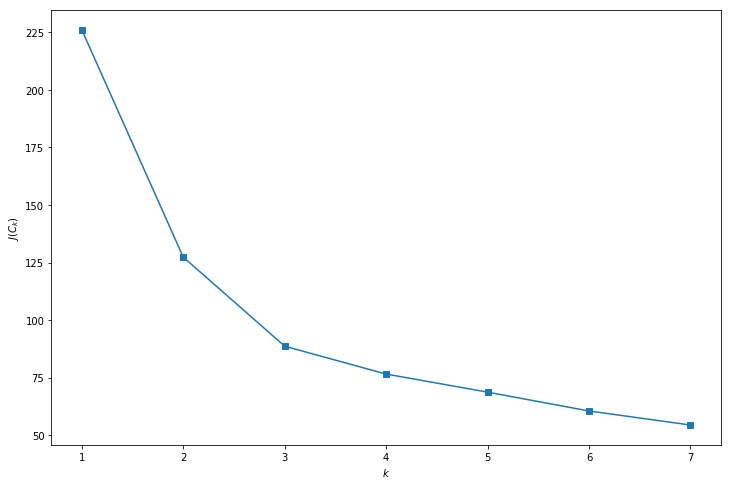

In [26]:
plt.figure(figsize=(12,8))
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(CZ)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## KMeans

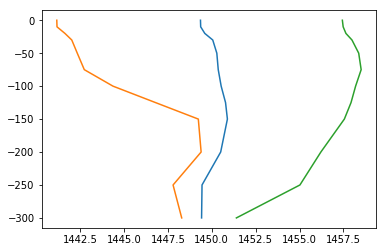

In [84]:
km = KMeans(n_clusters=3)
km.fit(CZ)
cluster_centers = km.cluster_centers_
for cl in cluster_centers:
    plt.plot(cl,zs)

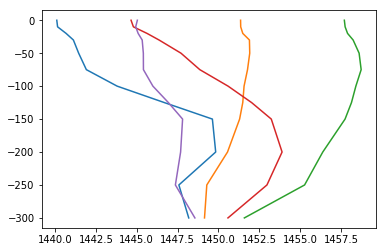

In [31]:
km = KMeans(n_clusters=5)
km.fit(CZ)
cluster_centers = km.cluster_centers_
for cl in cluster_centers:
    plt.plot(cl,zs)

## DBSCAN

In [164]:
for ep in [1,2,3,4,5,6,7,8]:
    for ms in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
        db = DBSCAN(eps=ep, min_samples=ms)
        db.fit(CZ)
        Lable = db.labels_
        lu = np.unique(Lable)
        le = []
        for l in lu:
            le.append(len(CZ[Lable==l]))
        st = np.std(le)
        le = len(le)
        if 2 < le < 7 and st < 30:
            print('eps = {0}, ms = {1}, len = {2}, std = {3}'.format(ep,ms,le,st))

eps = 2, ms = 5, len = 6, std = 27.60434748368452
eps = 3, ms = 6, len = 6, std = 15.91644851508443
eps = 3, ms = 7, len = 6, std = 18.850287354131588
eps = 3, ms = 8, len = 6, std = 20.033305601755625
eps = 3, ms = 9, len = 5, std = 24.576411454889016
eps = 3, ms = 10, len = 4, std = 28.64000698323937
eps = 3, ms = 11, len = 4, std = 28.64000698323937
eps = 4, ms = 7, len = 5, std = 20.610676844781203
eps = 4, ms = 8, len = 4, std = 19.80530232033836
eps = 4, ms = 9, len = 4, std = 19.80530232033836
eps = 4, ms = 10, len = 5, std = 15.556349186104045
eps = 4, ms = 11, len = 5, std = 14.546477236774544
eps = 4, ms = 12, len = 5, std = 15.11290838985005
eps = 4, ms = 13, len = 5, std = 15.11290838985005
eps = 4, ms = 14, len = 4, std = 24.253865671269807
eps = 5, ms = 11, len = 3, std = 11.51810169544733
eps = 5, ms = 12, len = 3, std = 11.51810169544733
eps = 5, ms = 13, len = 4, std = 21.02974084481309
eps = 5, ms = 14, len = 4, std = 21.02974084481309
eps = 5, ms = 15, len = 4, std =

In [170]:
db = DBSCAN(eps=6, min_samples=18)
db.fit(CZ)
Lable = db.labels_
lu = np.unique(Lable)

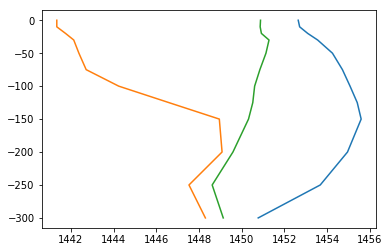

In [185]:
for lable in lu:
    plt.plot(np.mean(CZ[Lable==lable],axis=0),zs)

In [186]:
db = DBSCAN(eps=4, min_samples=11)
db.fit(CZ)
Lable = db.labels_
lu = np.unique(Lable)

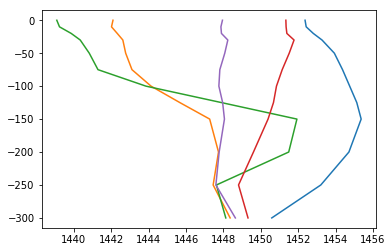

In [187]:
for lable in lu:
    plt.plot(np.mean(CZ[Lable==lable],axis=0),zs)